# User-based CF

해당 데이터는 movie ID, user ID, rating 컬럼만 존재. 다른 feature들이 존재하지 않으므로 User-based CF를 통한 예측이 가장 성능이 좋을 것이라고 판단.

## 데이터 불러오기 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_df = pd.read_csv('train.csv',index_col='ID')
test_df = pd.read_csv('test.csv',index_col='ID')

## EDA 및 전처리

In [4]:
train_df.head()

,movie,user,rating
ID,,,
610739,3704,3784,3
324753,1924,802,3
808218,4837,1387,4
133808,867,1196,4
431858,2631,3072,5


###  기본적인 구조 확인

#### 데이터 shape 확인

In [7]:
print(train_df.shape)
print(test_df.shape)

(750156, 3)
(250053, 2)


#### 결측값 및 중복값 확인

In [11]:
print(train_df.isna().sum())
print('-'*90)
print(test_df.isna().sum())

movie     0
user      0
rating    0
dtype: int64
------------------------------------------------------------------------------------------
user     0
movie    0
dtype: int64


In [12]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


### rating 분포 확인

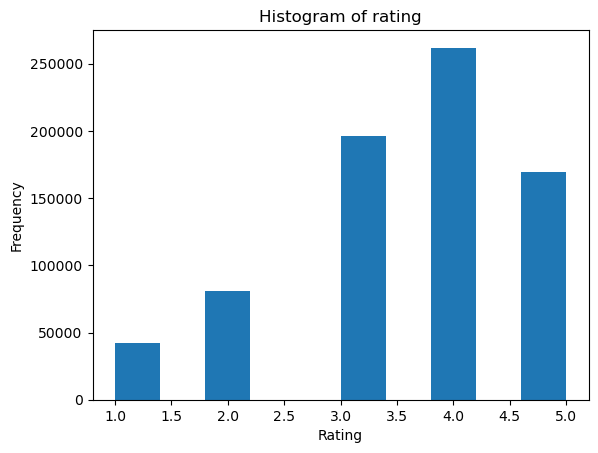

In [14]:
train_df['rating'].plot(kind='hist')
plt.title('Histogram of rating')
plt.xlabel('Rating')
plt.show()

평점 분포가 대체적으로 높게 이루어졌다는 것을 확인. 따라서 로그 변환 후 재확인

In [15]:
train_df['rating_log'] = np.log(train_df['rating'])

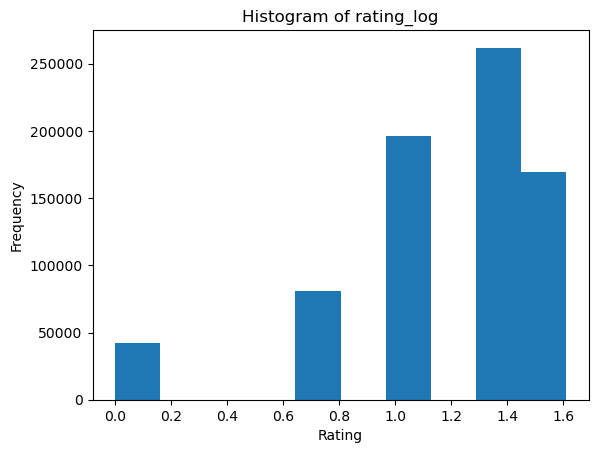

In [16]:
train_df['rating_log'].plot(kind='hist')
plt.title('Histogram of rating_log')
plt.xlabel('Rating')
plt.show()

큰 변화가 없으므로 기존 데이터 활용

In [17]:
del train_df['rating_log']

###  사용자별 리뷰 수 파악

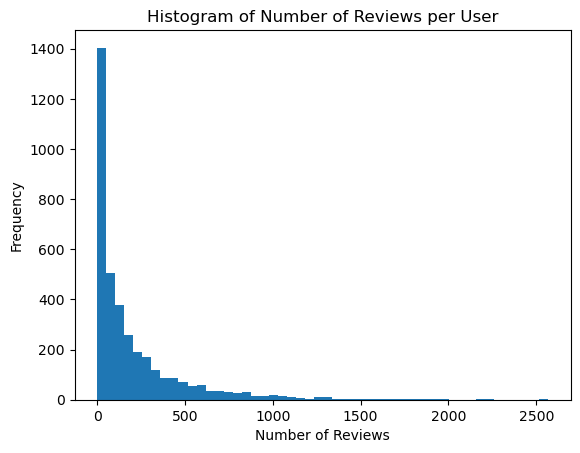

In [19]:
counts = train_df.groupby('user')['rating'].size().tolist() # 사용자별 리뷰 수 파악

#시각화
plt.hist(counts, bins=50) 
plt.title('Histogram of Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

히스토그램이 좌편향을 보이므로 일부 사용자만 많은 리뷰를 작성하고, 대부분의 사용자는 0~500개 정도의 리뷰를 작성했다는 것을 의미. 데이터가 소수의 사용자에 의해 왜곡돼 있을 가능성 존재. 따라서 User-based CF가 이 데이터에 적절하지 않을 수 있을 가능성이 높음.

## 사용자 간 유사도 계산

#### 유사도 계산 위해 피봇팅 진행

In [25]:
piv = train_df.pivot_table(index=['user'], columns=['movie'], values='rating')

In [26]:
piv

movie,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 사용자 개개인의 평가 척도 조정

점수를 상대적으로 짜게 주는 사람에 대한 조정 작업

In [47]:
piv_norm = piv.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1) 

In [48]:
piv_norm.head()

movie,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user,,,,,,,,,,,,,,,,,,,,,
1,0.214026,NaN,NaN,NaN,NaN,-0.035974,NaN,NaN,0.214026,0.214026,...,NaN,-0.035974,NaN,NaN,-0.035974,NaN,NaN,NaN,NaN,-0.285974
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.186000,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Null값 0으로 대체 

In [49]:

piv_norm.fillna(0, inplace=True)

piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

In [62]:
piv_norm

movie,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user,,,,,,,,,,,,,,,,,,,,,
1,0.214026,0.0,0.0,0.0,0.0,-0.035974,0.0,0.000,0.214026,0.214026,...,0.0,-0.035974,0.0,0.0,-0.035974,0.0,0.0,0.0,0.0,-0.285974
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.064,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,-0.186000,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.099219,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3949,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3950,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


#### csr_matrix로 인덱스를 압축하여 저장

In [63]:
import scipy as sp
piv_sparse = sp.sparse.csr_matrix(piv_norm.values)

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

#코사인 유사도
user_similarity = cosine_similarity(piv_sparse)

#item_similarity = cosine_similarity(piv_sparse)

In [71]:
#데이터 프레임화
user_sim_df = pd.DataFrame(user_similarity, index = piv_norm.index, columns = piv_norm.index)

#item_sim_df = pd.DataFrame(item_similarity, index = piv_norm.columns, columns = piv_norm.columns)

In [73]:
item_sim_df.head()

user,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.061995,0.029341,0.022948,0.037670,0.000274,0.046691,0.023761,0.008293,0.040337,...,-0.007988,0.001493,0.001101,0.016242,0.005469,0.045478,0.020623,-0.004615,0.011357,0.026015
2,0.061995,1.000000,0.023057,0.013896,0.085504,0.022270,0.050936,0.053581,0.078622,0.057016,...,-0.014938,-0.010019,0.023657,0.025907,0.013466,0.016680,-0.006828,-0.012504,-0.007678,0.003463
3,0.029341,0.023057,1.000000,0.059767,0.107955,0.050305,0.071529,0.023858,0.018995,0.033645,...,-0.004362,-0.002004,-0.002703,0.017489,0.009459,0.056531,-0.002419,0.030956,-0.000945,0.008862
4,0.022948,0.013896,0.059767,1.000000,0.111684,-0.008819,0.006072,0.012826,-0.028783,0.004679,...,0.010787,0.017225,0.000000,0.000000,-0.008552,0.006769,-0.024564,0.000000,-0.018963,0.022109
5,0.037670,0.085504,0.107955,0.111684,1.000000,0.004899,0.094771,0.071861,0.060964,0.044696,...,-0.015456,0.030235,0.015817,0.022552,0.034575,0.030226,-0.014869,0.003949,0.001198,-0.002115


from sklearn.metrics.pairwise import cosine_similarity

사용자-영화 행렬 생성
user_movie_matrix = pd.pivot_table(data=train_df, values='rating', index='user', columns='movie')

NaN 값을 0으로 대체
user_movie_matrix = user_movie_matrix.fillna(0)

사용자 간 코사인 유사도 계산
user_similarity = cosine_similarity(user_movie_matrix)

user_similarity를 DataFrame 형식으로 변환
user_similarity_df = pd.DataFrame(data=user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)


In [22]:
user_similarity_df

user,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.279881,0.211767,0.141590,0.191478,0.252348,0.227442,0.099047,0.083959,0.264279,...,0.077575,0.016375,0.042966,0.060515,0.035536,0.222000,0.143912,0.058048,0.033637,0.114787
2,0.279881,1.000000,0.215376,0.095235,0.226092,0.182248,0.201194,0.138344,0.141634,0.267187,...,0.058352,0.017683,0.064244,0.067042,0.078896,0.161717,0.130047,0.083938,0.016077,0.089501
3,0.211767,0.215376,1.000000,0.160307,0.255962,0.146229,0.250158,0.086200,0.120861,0.203014,...,0.024583,0.036340,0.028045,0.046663,0.044120,0.157606,0.074314,0.054639,0.005759,0.080191
4,0.141590,0.095235,0.160307,1.000000,0.234870,0.094506,0.171964,0.061235,0.038936,0.094364,...,0.047516,0.061978,0.000000,0.000000,0.017558,0.093336,0.076325,0.000000,0.016697,0.050896
5,0.191478,0.226092,0.255962,0.234870,1.000000,0.108299,0.244776,0.075869,0.111603,0.196879,...,0.026174,0.069796,0.048766,0.024674,0.019555,0.150339,0.057289,0.028590,0.013560,0.061325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.222000,0.161717,0.157606,0.093336,0.150339,0.189608,0.148702,0.050135,0.088537,0.181656,...,0.137262,0.058470,0.076280,0.132716,0.053674,1.000000,0.246909,0.114128,0.070596,0.283622
3949,0.143912,0.130047,0.074314,0.076325,0.057289,0.158218,0.080520,0.069742,0.083835,0.113739,...,0.183577,0.081358,0.073686,0.137413,0.103842,0.246909,1.000000,0.281207,0.134177,0.267010
3950,0.058048,0.083938,0.054639,0.000000,0.028590,0.087726,0.042091,0.061019,0.006134,0.086312,...,0.116184,0.243432,0.078170,0.135604,0.080605,0.114128,0.281207,1.000000,0.089429,0.135061


## 예측

In [85]:
# 예측 평점을 저장할 빈 리스트 정의
pred_ratings = []

# test_df에 있는 각 사용자-영화 쌍마다 반복
for idx, row in test_df.iterrows():
    # 사용자와 영화에 해당하는 인덱스 추출
    user = int(row['user'])
    movie = row['movie']
    
    # 사용자가 이미 해당 영화에 대한 평점을 매긴 경우 평균값 사용
    if movie in piv_norm.columns:
        pred_rating = piv_norm[movie].mean()
    else:
        movie_info = piv[piv['movie']==movie]
        if len(movie_info) == 0:
            # 해당 영화에 대한 정보가 없는 경우 기본값으로 3 사용
            pred_rating = 3.0
            continue
        else:
            movie_ratings = movie_info.iloc[:, 1:]
            movie_ratings = movie_ratings.to_numpy().flatten()
            pred_rating = movie_ratings.mean()

    if user in piv_norm.index:
        # 해당 사용자와 다른 모든 사용자들의 유사도를 검색해서 리스트로 만듦
        sim_scores = user_sim_df[user].sort_values(ascending=False)[1:]

        # 가장 유사한 N명의 사용자를 선택
        n_similar_users = 10
        similar_users = sim_scores.iloc[:n_similar_users].index

        # 가중평균 계산
        for sim_user in similar_users:
            # 해당 사용자의 영화 평점 정보 가져오기
            if movie in piv_norm.columns and sim_user in piv_norm.index:
                sim_user_rating = piv_norm.loc[sim_user, movie]

                # 해당 사용자와 선택한 비교 사용자 간의 유사도 가져오기
                sim_user_sim = user_sim_df.loc[user, sim_user]

                # 가중치 및 가중평균 계산
                pred_rating += sim_user_sim * sim_user_rating

    # 만약 예측 평점이 5를 초과하거나 0 미만인 경우, 5와 0 사이의 값으로 조정
    if pred_rating > 5:
        pred_rating = 5
    elif pred_rating < 0:
        pred_rating = 0
        
    # 예측 평점을 저장
    pred_ratings.append(pred_rating)

# 결과 출력
print(pred_ratings)

# 예측 값을 test_df에 추가
test_df['rating'] = pred_ratings

# 원래대로 단위가 복원된 예측 평점 출력
test_df['rating'] = test_df.apply(lambda row: row['rating']*(np.max(piv[row['movie']])-np.min(piv[row['movie']]))+np.mean(piv[row['movie']]), axis=1)
print(test_df)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



        user  movie    rating
ID                           
895537  5412   2683  4.379671
899740  5440    904  3.310526
55688    368   3717  3.780521
63728    425   1721  2.370787
822012  4942   3697  4.030681
...      ...    ...       ...
840992  5054    927  3.248227
149776   963    517  3.962201
539927  3320   3107  3.511987
563434  3467   1225  4.050897
428976  2611   3005  3.789665

[250053 rows x 3 columns]


In [86]:
test_df.head()

,user,movie,rating
ID,,,
895537,5412,2683,4.379671
899740,5440,904,3.310526
55688,368,3717,3.780521
63728,425,1721,2.370787
822012,4942,3697,4.030681


### 제출파일 추출

In [93]:
# test_df에서 rating 항목 추출
submission_df = test_df[['rating']]
submission_df.reset_index(inplace=True)

In [94]:
submission_df.head()

,ID,rating
0,895537,4.379671
1,899740,3.310526
2,55688,3.780521
3,63728,2.370787
4,822012,4.030681


In [95]:
submission_df.to_csv('sampleSubmission.csv', index=False)